In [5]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up directories based on where the program is being run from

In [6]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
model_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [5]:
all_cases = os.listdir('inp_validation//')
all_cases

['20200207_145043_singleparam_icenucmod_wbf_1_inp_1',
 '20200131_120822_singleparam_nimaxmod_wbf_1_inp_1',
 '20200109_nfclimo_f19tn14',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_120200207_145043_singleparam_icenucmod_wbf_1_inp_1cloudtop_slf_comparison.csv',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_1020200207_145043_singleparam_icenucmod_wbf_1_inp_10cloudtop_slf_comparison.csv',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_10',
 '20200128_162401_singleparam_altINPm1_wbf_1_inp_100',
 '20200128_142110_singleparam_frzrtvarsm1_wbf_1_inp_1',
 '20200131_120716_singleparam_nimaxmod_wbf_1_inp_100',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_120200207_145043_singleparam_icenucmod_wbf_1_inp_1_slf_comparison.png',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_1020200207_145043_singleparam_icenucmod_wbf_1_inp_10_slf_comparison.png',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_1',
 '20200128_162401_singleparam_altINPm1_wbf_1_inp_1']

In [18]:
case = '20200207_145043_singleparam_icenucmod_wbf_1_inp_10'

#model_dir = 'mnth15runs/%s/' % case # inconsistent label compared to jupy_test
model_dir = 'inp_validation/%s/' % case # inconsistent label compared to jupy_test
#model_dir = 'NorESM_validation/%s' % ct_val
os.path.exists(model_dir)

True

In [19]:
relevant_vars = [
     'CLDFREE', 'CLDHGH','CLDICE', 'CLDLIQ', 'CLDLOW','CLDMED',
     'CLDTAU','CLDTOT','CLD_ISOTM','CLD_ISOTM_NONSIM','CLD_SLF',
     'CLD_SLF_NONSIM','CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
     'CONCLD', 'BERGO','BERGOXCLD_ISOTM','BERGOXCLD_ISOTM_NONSIM',
     'BERGSO','BERGSOXCLD_ISOTM','BERGSOXCLD_ISOTM_NONSIM',
     'MG_SADICE','MG_SADLIQ','MNUCCCO','MNUCCDO','MNUCCDOhet',
     'MNUCCRO','MNUCCTO','NUMICE','NUMLIQ','NUMRAI','NUMSNO',
     'N_AER','PRECIPBINOCC_CC','PRECIPBINOCC_CL','PRECIPBINOCC_CT',
     'PRECIPBINRATE_CC','PRECIPBINRATE_CL','PRECIPBINRATE_CT', 
     'SADICEXCLD_ISOTM','SADICEXCLD_ISOTM_NONSIM','SADLIQXCLD_ISOTM',
     'SADLIQXCLD_ISOTM_NONSIM','SLFXCLD_ISOTM','SLFXCLD_ISOTM_NONSIM',
     'cell_weight','SLF_ISOTM','SLF_ISOTM_AVG', 'TS', 'AREI'
    ]

### Process CALIOP data

First, check if the output file already already exists.

In [20]:
data_string = obs_dir + 'MPC_ISO_CALIOP_NorESM.csv'
caliop_processed = os.path.exists(data_string)

#Pick out the right files
file_str = '.dat'
obs_files = os.listdir(obs_dir) # All files in directory
slf_files = [x for x in obs_files if file_str in x]   # files with the CALIOP string
slf_files.sort()

if caliop_processed:
    print('Grabbing data from %s' % data_string)
    all_caliop = pd.read_csv(data_string)

else:
    print('Writing data to %s' % data_string)
    all_caliop = process_caliop(slf_files, obs_dir)
    
    all_caliop.to_csv(path_or_buf = data_string)

all_caliop = all_caliop.set_index('Isotherm')
all_caliop

Grabbing data from caliop_slfs/MPC_ISO_CALIOP_NorESM.csv


,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average
Isotherm,,,,,,,,,,
-40,0,0,0,0,0,0,0,0,0,0.000000
-30,4,6,5,7,3,9,5,12,6,5.578054
-20,26,32,28,30,21,37,26,39,31,28.670216
-10,62,64,63,60,56,70,56,61,55,61.357769
0,100,100,100,100,100,100,100,100,100,100.000000


This currently doesn't really work

In [21]:
model_dir

'inp_validation/20200207_145043_singleparam_icenucmod_wbf_1_inp_10/'

In [22]:
data_path = model_dir + case + '_slf_processed.nc'
noresm_processed = os.path.exists(data_path)

# Work around
noresm_processed = False

if noresm_processed:
    print('Grabbing data from %s' % data_path)
    ds = xr.open_dataset(data_path)

else:
    print('Processing data from %s' % (model_dir + case))
    ds = process_for_slf(model_dir + case, relevant_vars)
#    ds.to_netcdf(data_path)

Processing data from inp_validation/20200207_145043_singleparam_icenucmod_wbf_1_inp_10/20200207_145043_singleparam_icenucmod_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
data_string = '%s%s_slf_caliop_comparison.csv' % (model_dir, case)

all_slf_processed = os.path.exists(data_string)
all_slf_processed=False # just to reset and add stdev
if all_slf_processed:
    print('Loading from %s' % data_string)
    all_slf = pd.read_csv(data_string)
    
else:
    print('Processing from netcdf-based xarray object and saving to %s' % data_string)
    df = noresm_slf_to_df(ds, slf_files)
    
    all_slf = pd.concat([all_caliop, df], axis=1, sort=False)
    all_slf['Arctic Error'] = all_slf['NorESM_90N-70N'] - all_slf['CALIOP_90N-70N']
    all_slf['Global Error'] = all_slf['NorESM_Average'] - all_slf['CALIOP Average']

    all_slf.to_csv(path_or_buf = data_string)

# Catch an annoying error
try:
    all_slf = all_slf.set_index('Isotherm')
except: pass    

all_slf_clean = all_slf.dropna()

Processing from netcdf-based xarray object and saving to inp_validation/20200207_145043_singleparam_icenucmod_wbf_1_inp_10/20200207_145043_singleparam_icenucmod_wbf_1_inp_10_slf_caliop_comparison.csv


In [24]:
all_slf

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,...,NorESM_50S-70S,NorESM_50S-70S_STD,NorESM_70N-50N,NorESM_70N-50N_STD,NorESM_70S-90S,NorESM_70S-90S_STD,NorESM_90N-70N,NorESM_90N-70N_STD,Arctic Error,Global Error
Isotherm,,,,,,,,,,,,,,,,,,,,,
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.777474,2.891401,0.898295,2.172610,3.333678,6.399385,0.185090,2.867757,0.185090,1.085431
-35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.424870,7.047807,3.274841,5.426847,14.336013,14.569727,0.522092,3.890346,NaN,NaN
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,...,11.574143,9.049913,5.838554,8.127510,16.128460,15.069548,2.288599,10.378241,-3.711401,1.437120
-25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.134293,9.669197,8.167769,9.997910,19.542169,14.889616,3.287646,10.836533,NaN,NaN
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,...,25.440142,11.544482,14.017253,13.496926,25.280915,16.706045,4.946724,14.742962,-26.053276,-13.502164
-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.062637,13.607733,23.340843,17.301582,34.484936,18.051950,11.148534,25.164667,NaN,NaN
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,...,50.111248,11.565986,34.910702,21.504000,44.859604,21.522257,5.621472,17.050886,-49.378528,-24.685732
-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.771185,13.122209,52.703236,24.908356,54.861100,28.004963,9.892524,25.076982,NaN,NaN
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,...,87.902486,16.909204,84.021778,26.673054,71.677537,31.797585,49.655793,38.585033,-50.344207,-12.261176


In [25]:
all_slf_clean

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,...,NorESM_50S-70S,NorESM_50S-70S_STD,NorESM_70N-50N,NorESM_70N-50N_STD,NorESM_70S-90S,NorESM_70S-90S_STD,NorESM_90N-70N,NorESM_90N-70N_STD,Arctic Error,Global Error
Isotherm,,,,,,,,,,,,,,,,,,,,,
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.777474,2.891401,0.898295,2.172610,3.333678,6.399385,0.185090,2.867757,0.185090,1.085431
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,...,11.574143,9.049913,5.838554,8.127510,16.128460,15.069548,2.288599,10.378241,-3.711401,1.437120
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,...,25.440142,11.544482,14.017253,13.496926,25.280915,16.706045,4.946724,14.742962,-26.053276,-13.502164
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,...,50.111248,11.565986,34.910702,21.504000,44.859604,21.522257,5.621472,17.050886,-49.378528,-24.685732
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,...,87.902486,16.909204,84.021778,26.673054,71.677537,31.797585,49.655793,38.585033,-50.344207,-12.261176


Text(0.5,0.98,'20200207_145043_singleparam_icenucmod_wbf_1_inp_10')

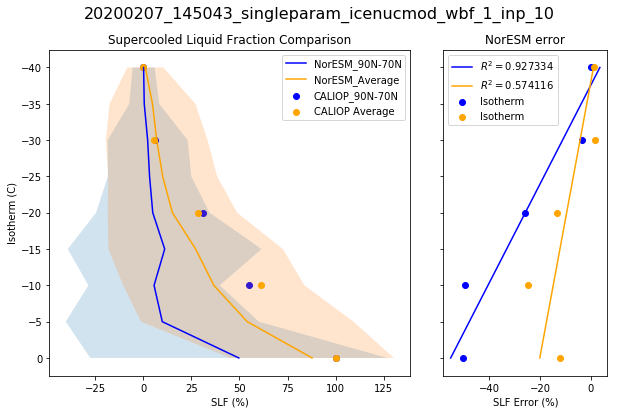

In [26]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
axes = [f1_ax1, f1_ax2]
plt.setp(f1_ax2.get_yticklabels(), visible=False)

isos = np.array(all_slf_clean.index).reshape(-1,1)

fig1.gca().invert_yaxis()
f1_ax1.set_title('Supercooled Liquid Fraction Comparison'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

colors = ['blue', 'orange']
models = ['NorESM_90N-70N', 'NorESM_Average']
caliops = ['CALIOP_90N-70N', 'CALIOP Average']
errors = ['Arctic Error', 'Global Error']

# Wrap everything up and iterate!
for color, model, caliop, error in zip(colors, models, caliops, errors):
    f1_ax1.plot(all_slf[model], all_slf.index, label=model, color = color) # caliop values
    f1_ax1.fill_betweenx(all_slf.index, all_slf[model] - 2*all_slf[model + "_STD"], all_slf[model] + 2*all_slf[model + "_STD"], alpha=0.2)
    
    f1_ax1.scatter(all_slf[caliop], all_slf.index, label=caliop, color = color)
    f1_ax2.scatter(all_slf[error], all_slf.index, color=color)
    _r = regress_1d(isos, all_slf_clean[error])
    _s = _r.score(isos, all_slf_clean[error])
    f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))
    
#f1_ax2.set_xlim((-30,10))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)

In [27]:
filename = '%s_slf_comparison.png' % case
filename
if not os.path.exists(filename):
    fig1.savefig(model_dir + filename,format = 'png', dpi = 200)
    fig1.clf()

Plot the global SLF at each isotherm

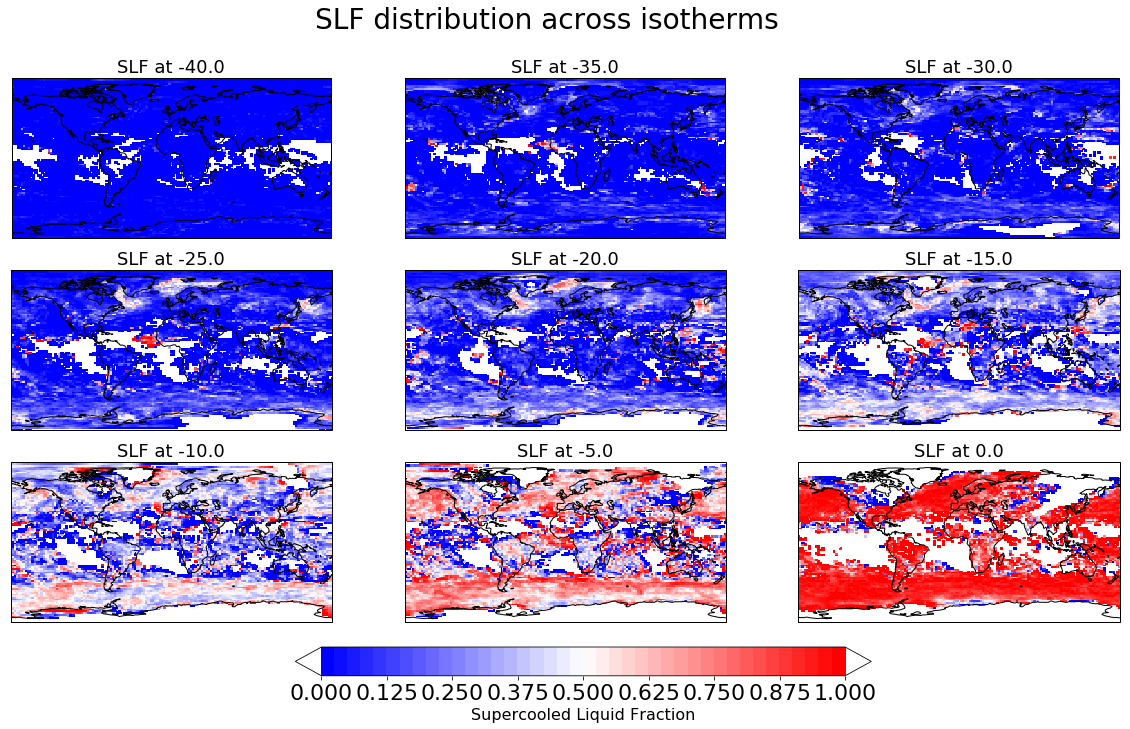

In [41]:
iso_fig = plot_slf_isotherms(ds)

In [42]:
filename = '%s_noresm_slf_isotherms.png' % case
filename
if not os.path.exists(filename):
    iso_fig.savefig(model_dir + filename,format = 'png', dpi = 200)
    iso_fig.clf()

In [3]:
mods_dir = 'inp_validation/'

In [23]:
cc = '20200128_142110_singleparam_frzrtvarsm1_wbf_1_inp_1'
controlcontrol = xr.open_dataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, cc, cc))

c = '20200207_145043_singleparam_icenucmod_wbf_1_inp_1'
control = xr.open_dataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, c, c))


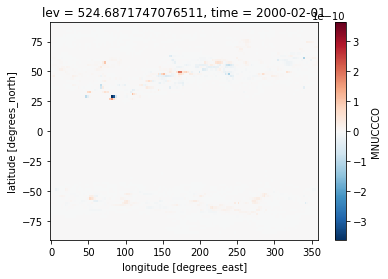

In [20]:
(controlcontrol['MNUCCCO'][0,20,:,:]-control['MNUCCCO'][0,20,:,:]).plot()

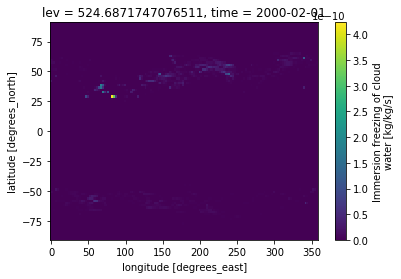

In [21]:
control['MNUCCCO'][0,20,:,:].plot()

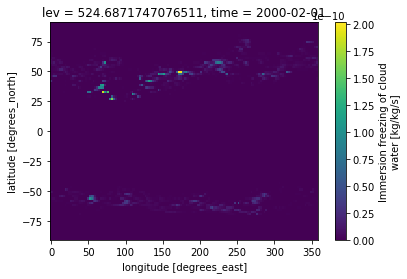

In [22]:
controlcontrol['MNUCCCO'][0,20,:,:].plot()